In [1]:
# !pip install stellargraph[demos]
# !pip install tf-nightly

In [1]:
import stellargraph as sg
import os
import sys
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from stellargraph.layer import GCN_LSTM

import datetime
import random
random.seed(45)
tf.random.set_seed(10)

2022-03-16 16:52:10.199154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 16:52:10.199343: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-16 16:52:17.680982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 16:52:17.681182: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 16:52:17.681329: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-F3GKG0K): /proc/driver/nvidia/version does not exist
2022-03-16 16:52:17.682495: I tensorflow/core/platform/cpu_fe

In [2]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [3]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [4]:
def data_preparation(datafile1):
    #Put the file location
    df = pd.read_csv(datafile1)
    
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    # TODO: Add buffer and consider train-data for range
    # lat_range = {'min': df.lat.min(), 'max': df.lat.max()}
    # long_range = {'min': df.long.min(), 'max': df.long.max()}
    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)
    means = df[["lat_grid", "long_grid", "pm2_5"]].groupby(['lat_grid', 'long_grid']).mean().reset_index()['pm2_5'].values

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute

    # only PM2_5
    df = df[['dateTime','lat_grid','long_grid','pm2_5']]
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
#     df = df.fillna(method='ffill')
#     df = df.fillna(method='bfill')
#     df = df.interpolate(limit_direction="both")
#     df = df.interpolate(method='spline', order=3)
#     df = df.fillna(0)
    columns = df.columns
    df = df[columns[2:]]
    df = df.fillna(0)
#     df['means'] = means
    return df

# Fill missing values

In [5]:
# !pip install missingno

In [6]:
# import missingno as msno
# import matplotlib.pyplot as plta
# df = data_preparation('PM Datasets/2021-01-23_all.csv')
# # msno.bar(df, figsize=(12, 6), fontsize=12, color='steelblue')
# msno.bar(df, color='steelblue')

In [7]:
# df

In [8]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# df = data_preparation('PM Datasets/2021-01-23_all.csv')
# imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=5)
# imputed_dataset = imputer.fit_transform(df)

In [9]:
def my_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
#     mask = tf.sign(y_true)
#     print(mask[mask>0])
#     y_pred = y_pred*(mask)
    loss = mse(y_pred[y_true>0], y_true[y_true>0] )
#     loss = mse(tf.reshape(y_true,(-1,)),tf.reshape(y_pred,(-1,)))
#     print(loss)
    return loss

In [29]:
def train_test_split(df, grid_points_indices, train_portion, known_portion):
    time_len = df.shape[1]
    points_len = df.shape[0]
    train_size = int(time_len * train_portion) + 1
    train_data = df.iloc[:, :train_size]
    known_size = int(points_len * known_portion)
    train_known_indices = random.sample(list(train_data.index), known_size)
    train_known_data = train_data.loc[train_known_indices, :] 
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_known_data = train_known_data.reindex(grid_points_indices,fill_value=0)
    train_data = np.array(train_data)
    train_known_data = np.array(train_known_data)
    
    test_data = df.iloc[:, train_size:]
    test_known_indices = random.sample(list(test_data.index), known_size)
    test_known_data = test_data.loc[test_known_indices, :] 
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_known_data = test_known_data.reindex(grid_points_indices,fill_value=0)
    test_data = np.array(test_data)
    test_known_data = np.array(test_known_data)
    return train_data, train_known_data, test_data, test_known_data

In [11]:
def scale_data(train_data, train_known_data, test_data, test_known_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_data = (train_data - min_pm) / (max_pm - min_pm)
    train_known_data = (train_known_data - min_pm) / (max_pm - min_pm)
    test_data = (test_data - min_pm) / (max_pm - min_pm)
    test_known_data = (test_known_data - min_pm) / (max_pm - min_pm)
    return train_data, train_known_data, test_data, test_known_data

In [12]:
# df = data_preparation('PM Datasets/2020-12-01_all.csv')
# train_data, train_known_data, test_data, test_known_data = train_test_split(df, grid_points_indices, seq_len, train_portion = 0.8, known_portion = 0.8)

In [13]:
# print("Train data: ", train_data.shape)
# print("Train known data: ", train_known_data.shape)
# print("Test data: ", test_data.shape)
# print("Test known data: ", test_known_data.shape)

In [14]:
# df

In [15]:
def sequence_data_preparation(seq_len, train_data, train_known_data, test_data, test_known_data): 
    trainX, trainY, testX, testY = [], [], [], []
    
    for i in range(train_data.shape[1] - int(seq_len - 1)):
        trainX.append(train_known_data[:, i : i + seq_len])
        trainY.append(train_data[:, i : i + seq_len])        
    for i in range(test_data.shape[1] - int(seq_len - 1)):
        testX.append(test_known_data[:, i : i + seq_len])
        testY.append(test_data[:, i : i + seq_len])
        
    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [16]:

# seq_len = 4
# known_portion = 0.8
# time_len = df.shape[1]
# points_len = df.shape[0]
# # train_size = int(time_len * train_portion) 
# train_size = time_len - seq_len
# known_size = int(points_len * known_portion)
# unknown_size = points_len - known_size

# #train-test split
# train_data = df.iloc[:, :train_size]
# test_data = df.iloc[:, train_size:]

# #rescale
# max_pm = train_data.max()
# min_pm = train_data.min()
# train_data = (train_data - min_pm) / (max_pm - min_pm)
# test_data = (test_data - min_pm) / (max_pm - min_pm)
# #known, unknown split in each batch
# trainX, trainY, testX, testY = [], [], [], []
# for i in range(train_data.shape[1] - int(seq_len - 1)):
#     train_data_batch = train_data.iloc[:, i : i + seq_len]
#     train_unknown_indices = random.sample(list(train_data_batch.index), unknown_size)
#     train_known_indices = set(train_data_batch.index) - set(train_unknown_indices)
#     train_known_data_batch = train_data_batch.loc[train_known_indices, :] 
#     train_known_data_batch = train_known_data_batch.reindex(grid_points_indices,fill_value=0)
#     train_data_batch = train_data_batch.reindex(grid_points_indices,fill_value=0)
#     trainX.append(train_known_data_batch)
#     trainY.append(train_data_batch)
    
# for i in range(test_data.shape[1] - int(seq_len - 1)):
#     test_data_batch = test_data.iloc[:, i : i + seq_len]
#     test_unknown_indices = random.sample(list(test_data_batch.index), unknown_size)
#     test_known_indices = set(test_data_batch.index) - set(test_unknown_indices)
#     test_known_data_batch = test_data_batch.loc[test_known_indices, :] 
#     test_known_data_batch = test_known_data_batch.reindex(grid_points_indices,fill_value=0)
#     test_data_batch = test_data_batch.reindex(grid_points_indices,fill_value=0)
#     testX.append(test_known_data_batch)
#     testY.append(test_data_batch)
    
# trainX = np.array(trainX)
# trainY = np.array(trainY)
# testX = np.array(testX)
# testY = np.array(testY)

# print(trainX.shape)
# print(trainY.shape)
# print(testX.shape)
# print(testY.shape)
# #     return trainX, trainY, testX, testY

In [17]:
# seq_len = 4
# trainX, trainY, testX, testY = sequence_data_preparation(
#     seq_len, train_data, train_known_data, test_data, test_known_data
# )
# print(trainX.shape)
# print(trainY.shape)
# print(testX.shape)
# print(testY.shape)


In [18]:
def prepare_train_data(df, grid_points_indices, train_portion, known_portion):
    train_data, train_known_data, test_data, test_known_data = train_test_split(df, grid_points_indices, seq_len, train_portion, known_portion)
    print("Train data: ", train_data.shape)
    print("Test data: ", test_data.shape)
    train_data, train_known_data, test_data, test_known_data = scale_data(train_data, train_known_data, test_data, test_known_data)
    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, train_data, train_known_data, test_data, test_known_data
    )
    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)
    return trainX, trainY, testX, testY, train_data

In [19]:
def train_model(trainX, trainY, testX, testY, train_data, n_epochs):
    cb = TimingCallback()

    history = model.fit(
            trainX,
            trainY,
            epochs = n_epochs,
            batch_size = 1,
            shuffle=True,
            verbose=0,
            validation_data=[testX, testY],
            callbacks=[cb]
        )

    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)

    print(
        "Mean Train loss: ",
        sum(tf.sqrt(history.history["loss"]))*max_pm/len(history.history["loss"]),
        "\n Last Train loss: ",
        tf.sqrt(history.history["loss"][-1])*max_pm,
        "\n Mean Test loss:",
        sum(tf.sqrt(history.history["val_loss"]))*max_pm/len(history.history["val_loss"]),
        "\n Last Test loss:",
        tf.sqrt(history.history["val_loss"][-1])*max_pm,
    #     "\nTrain time ", traintime,
        "\n Train time callbacks", sum(cb.logs)
        
    )
    sg.utils.plot_history(history)

In [20]:
def eval(model, testX, testY):
    output = model.predict(trainX)
    # yhat = model.predict(testX)

    ## actual train and test values
    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_true = np.array((trainY * (max_pm - min_pm)) + min_pm)
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)

    ## Rescale model predicted values
    train_output = np.array((output * (max_pm - min_pm)) + min_pm)
    # test_rescpred = np.array((yhat * (max_pm - min_pm)) + min_pm)

    # # Masked predicted values
    # mask_train = tf.sign(trainY)
    mask_test = tf.sign(testY)
    # train_rescpred = train_rescpred*(mask_train)
    test_output = train_output*(mask_test)
    test_mse = my_loss(test_true, train_output)
    test_rmse = tf.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [21]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 4

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [22]:
gcn_lstm = GCN_LSTM(
        seq_len=seq_len,
        adj=adj,
        gc_layer_sizes=[8, 16],
        gc_activations=["relu", "relu"],
        lstm_layer_sizes=[16, 16],
        lstm_activations=["tanh", "tanh"],
    )
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
opt = tf.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer=opt, loss=my_loss)
print(model.summary())

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:7: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  import sys


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 270, 2)]          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 270, 2, 1)        0         
                                                                 
 reshape (Reshape)           (None, 270, 2)            0         
                                                                 
 fixed_adjacency_graph_convo  (None, 270, 8)           73186     
 lution (FixedAdjacencyGraph                                     
 Convolution)                                                    
                                                                 
 fixed_adjacency_graph_convo  (None, 270, 16)          73298     
 lution_1 (FixedAdjacencyGra                                     
 phConvolution)                                              

In [23]:
# df = data_preparation('PM Datasets/2021-01-23_all.csv')
# trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_portion = 0.8, known_portion = 0.8)
# max_pm = train_data.max()
# min_pm = train_data.min()
# train_model(trainX, trainY, testX, testY, train_data, n_epochs = 100)

In [24]:

# seq_len = 4
# known_portion = 0.8
# time_len = df.shape[1]
# points_len = df.shape[0]
# # train_size = int(time_len * train_portion) 
# train_size = time_len - seq_len
# known_size = int(points_len * known_portion)
# unknown_size = points_len - known_size

# #train-test split
# train_data = df.iloc[:, :train_size]
# test_data = df.iloc[:, train_size:]

# #rescale
# max_pm = train_data.max()
# min_pm = train_data.min()
# train_data = (train_data - min_pm) / (max_pm - min_pm)
# test_data = (test_data - min_pm) / (max_pm - min_pm)
# #known, unknown split in each batch
# trainX, trainY, testX, testY = [], [], [], []
# for i in range(train_data.shape[1] - int(seq_len - 1)):
#     train_data_batch = train_data.iloc[:, i : i + seq_len]
#     train_unknown_indices = random.sample(list(train_data_batch.index), unknown_size)
#     train_known_indices = set(train_data_batch.index) - set(train_unknown_indices)
#     train_known_data_batch = train_data_batch.loc[train_known_indices, :] 
#     train_known_data_batch = train_known_data_batch.reindex(grid_points_indices,fill_value=0)
#     train_data_batch = train_data_batch.reindex(grid_points_indices,fill_value=0)
#     trainX.append(train_known_data_batch)
#     trainY.append(train_data_batch)
    
# for i in range(test_data.shape[1] - int(seq_len - 1)):
#     test_data_batch = test_data.iloc[:, i : i + seq_len]
#     test_unknown_indices = random.sample(list(test_data_batch.index), unknown_size)
#     test_known_indices = set(test_data_batch.index) - set(test_unknown_indices)
#     test_known_data_batch = test_data_batch.loc[test_known_indices, :] 
#     test_known_data_batch = test_known_data_batch.reindex(grid_points_indices,fill_value=0)
#     test_data_batch = test_data_batch.reindex(grid_points_indices,fill_value=0)
#     testX.append(test_known_data_batch)
#     testY.append(test_data_batch)
    
# trainX = np.array(trainX)
# trainY = np.array(trainY)
# testX = np.array(testX)
# testY = np.array(testY)

# print(testX.shape)
# print(trainX.shape)
# print(trainY.shape)
# print(testY.shape)
# #     return trainX, trainY, testX, testY

In [25]:
# train_model(trainX, trainY, testX, testY, train_data, n_epochs = 100)

In [26]:
# n_epochs = 100
# train_loss_array = []
# train_rmse_array = []
# test_loss_array = []
# test_rmse_array = []
# x = trainX
# y = trainY
# x_val = testX
# y_val = testY
# for epoch in range(n_epochs):
    
#     with tf.GradientTape() as tape: # Forward pass
#         y_ = model(x, training=True)
#         loss = my_loss(y_true=y, y_pred=y_)
#     grad = tape.gradient(loss, model.trainable_variables) # Backpropagation
#     opt.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
#     train_loss_array.append(loss)
#     train_rmse_array.append(tf.sqrt(loss))
# #     print(loss)
    
#     y_test = model.predict(x_val) # Validation predictions
#     test_loss = my_loss(y_true=y_val, y_pred=y_test)
#     test_loss_array.append(test_loss)
#     test_rmse_array.append(tf.sqrt(test_loss))
# #     print(test_loss)

In [30]:
df = data_preparation('PM Datasets/2020-12-01_all.csv')
train_data, train_known_data, test_data, test_known_data = train_test_split(df, grid_points_indices, train_portion = 0.8, known_portion = 0.8)

for i in range(2, 16):

    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    df = data_preparation(datafile)
    train_data1, train_known_data1, test_data1, test_known_data1 = train_test_split(df, grid_points_indices, train_portion = 0.8, known_portion = 0.8)
    train_data = np.hstack((train_data, train_data1))
    train_known_data = np.hstack((train_known_data, train_known_data1))
    test_data = np.hstack((test_data, test_data1))
    test_known_data = np.hstack((test_known_data, test_known_data1))
# for i in range(1, 16):
#     if i<10:
#         datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
#     else:
#         datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
#     df = data_preparation(datafile)
#     train_data1, test_data1 = train_test_split(df, grid_points_indices, train_size = 0.8)
#     train_data = np.hstack((train_data, train_data1))
#     test_data = np.hstack((test_data, test_data1))

print("Train data: ", train_data.shape)
print("Train known data: ", train_known_data.shape)
print("Test data: ", test_data.shape)
print("Test known data: ", test_known_data.shape)
train_data_scaled, train_known_data_scaled, test_data_scaled, test_known_data_scaled = scale_data(train_data, train_known_data, test_data, test_known_data)
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, train_data_scaled, train_known_data_scaled, test_data_scaled, test_known_data_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


Train data:  (270, 75)
Train known data:  (270, 75)
Test data:  (270, 15)
Test known data:  (270, 15)
(74, 270, 2)
(74, 270, 2)
(14, 270, 2)
(14, 270, 2)


In [32]:
df

dateTime                  360         540         720         900   \
lat_grid long_grid                                                   
0        22         142.573068  130.598228  148.280303  136.761381   
1        21         132.484177  132.542683  136.523622  135.229947   
         22         137.105848  121.361186  126.135398  135.811395   
2        21         130.410824  131.118451  136.847015  140.408297   
         22           0.000000    0.000000  130.000000    0.000000   
...                        ...         ...         ...         ...   
18       20         100.760000  182.611413  162.959424  149.366762   
         23          88.647059  168.642857    0.000000  129.969388   
         24         100.178571  175.810458    0.000000  143.535294   
19       19         101.153846  169.913978  155.273585  161.712329   
         20         107.134426  159.189355  134.943894  163.376344   

dateTime                  1080        1260  
lat_grid long_grid                          
0        22         146.409807  174.528029  
1        21         164.258065  193.190045  
         22         140.482353  184.183190  
2        21         169.195122  189.194896  
         22           0.000000    0.000000  
...                        ...         ...  
18       20         153.601575  188.482507  
         23           0.000000  154.554348  
         24           0.000000  189.160839  
19       19         148.464789  183.433566  
         20         141.913690  161.940994  

[130 rows x 6 columns]

In [ ]:
# n_epochs = 100
# train_loss_array = []
# train_rmse_array = []
# test_loss_array = []
# test_rmse_array = []
# x = trainX
# y = trainY
# x_val = testX
# y_val = testY
# for epoch in range(n_epochs):
    
#     with tf.GradientTape() as tape: # Forward pass
#         y_ = model(x, training=True)
#         loss = my_loss(y_true=y, y_pred=y_)
#     grad = tape.gradient(loss, model.trainable_variables) # Backpropagation
#     opt.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
#     train_loss_array.append(loss)
#     train_rmse_array.append(tf.sqrt(loss))
# #     print(loss)
    
#     y_test = model.predict(x_val) # Validation predictions
#     test_loss = my_loss(y_true=y_val, y_pred=y_test)
#     test_loss_array.append(test_loss)
#     test_rmse_array.append(tf.sqrt(test_loss))
# #     print(test_loss)

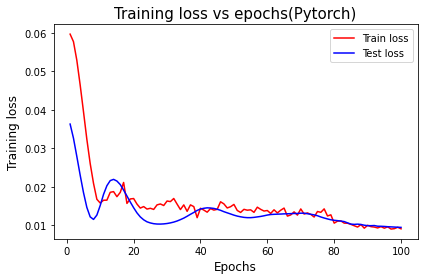

In [39]:
# import matplotlib.pyplot as plt
# titleFontSize = 15
# labelFontSize = 12
# tickFontSize = 10
# legendFontSize = 10
# labelStr = "size = "
# yLabel = "% of test points with lower error"
# xLabel = "Error %"
# count_arr = [i for i in range(1, len(train_loss_array) + 1)]
# plt.plot(count_arr, train_loss_array, label = "Train loss", color='red')
# plt.plot(count_arr, test_loss_array, label = "Test loss", color='blue')
# plt.title("Training loss vs epochs(Pytorch)", fontsize=titleFontSize)
# plt.xlabel("Epochs", fontsize=labelFontSize)
# plt.ylabel("Training loss", fontsize=labelFontSize)
# plt.xticks(fontsize=tickFontSize)
# plt.yticks(fontsize=tickFontSize)
# plt.tight_layout()
# plt.legend(prop={"size": legendFontSize})
# # plt.savefig("pytorch_loss.png")

Mean Train loss:  tf.Tensor(52.60636, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(49.928898, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(64.72964, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(68.25254, shape=(), dtype=float32) 
 Train time callbacks 325.1649196999988


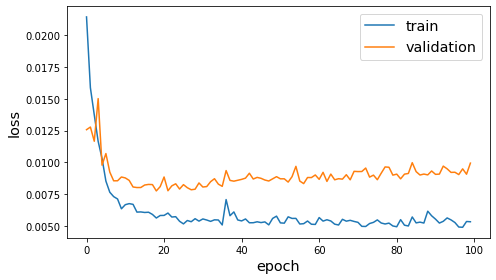

In [31]:
train_model(trainX, trainY, testX, testY, train_data, n_epochs = 100)

In [34]:
# import matplotlib.pyplot as plt
# titleFontSize = 15
# labelFontSize = 12
# tickFontSize = 10
# legendFontSize = 10
# labelStr = "size = "
# yLabel = "% of test points with lower error"
# xLabel = "Error %"
# count_arr = [i for i in range(1, len(train_loss_array) + 1)]
# plt.plot(count_arr, train_loss_array, label = "Train loss", color='red')
# plt.plot(count_arr, test_loss_array, label = "Test loss", color='blue')
# plt.title("Training loss vs epochs(Pytorch)", fontsize=titleFontSize)
# plt.xlabel("Epochs", fontsize=labelFontSize)
# plt.ylabel("Training loss", fontsize=labelFontSize)
# plt.xticks(fontsize=tickFontSize)
# plt.yticks(fontsize=tickFontSize)
# plt.tight_layout()
# plt.legend(prop={"size": legendFontSize})
# # plt.savefig("pytorch_loss.png")